In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from sklearn.manifold import TSNE
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

Classification of user at risk of churn


Accuracy: 0.7866666666666666
ROC-AUC: 0.7868673233748703
              precision    recall  f1-score   support

           0       0.76      0.79      0.78       281
           1       0.81      0.78      0.80       319

    accuracy                           0.79       600
   macro avg       0.79      0.79      0.79       600
weighted avg       0.79      0.79      0.79       600



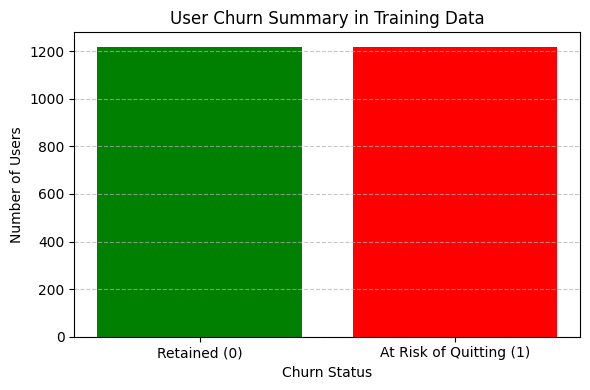

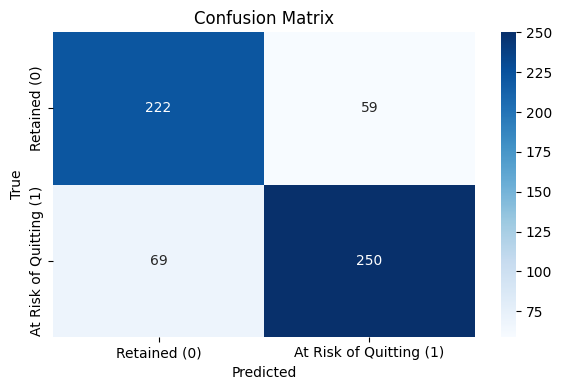

In [2]:
data = pd.read_csv("health_fitness_dataset.csv")

data = pd.get_dummies(data, columns=['gender', 'activity_type', 'intensity', 'smoking_status'], drop_first=True)

entry_counts = data['participant_id'].value_counts()
data['churn'] = data['participant_id'].map(lambda pid: 1 if entry_counts[pid] < 230 else 0)

agg_funcs = {
    'age': 'first',
    'height_cm': 'first',
    'weight_kg': 'mean',
    'calories_burned': 'mean',
    'avg_heart_rate': 'mean',
    'bmi': 'mean',
    'fitness_level': 'mean'
}

categorical_cols = [col for col in data.columns if col.startswith(('gender_', 'activity_type_', 'intensity_', 'smoking_status_'))]
for col in categorical_cols:
    agg_funcs[col] = 'mean'

aggregated = data.groupby('participant_id').agg(agg_funcs).reset_index()

aggregated['churn'] = aggregated['participant_id'].map(lambda pid: 1 if entry_counts[pid] < 230 else 0)

X = aggregated.drop(columns=['participant_id', 'churn'])
y = aggregated['churn']

X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train_raw)

model = RandomForestClassifier(n_estimators=100, random_state=None)
model.fit(X_train_bal, y_train_bal)

y_pred = model.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test_raw, y_pred))
print("ROC-AUC:", roc_auc_score(y_test_raw, y_pred))
print(classification_report(y_test_raw, y_pred))

churn_count = pd.Series(y_train_bal).value_counts()
total_users = len(y_train_bal)
   
labels = ['Retained (0)', 'At Risk of Quitting (1)']
counts = [churn_count.get(0, 0), churn_count.get(1, 0)]

plt.figure(figsize=(6, 4))
plt.bar(labels, counts, color=['green', 'red'])
plt.title('User Churn Summary in Training Data')
plt.ylabel('Number of Users')
plt.xlabel('Churn Status')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

conf_matrix = confusion_matrix(y_test_raw, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=['Retained (0)', 'At Risk of Quitting (1)'], yticklabels=['Retained (0)', 'At Risk of Quitting (1)'])
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()


Clustering the users in different groups

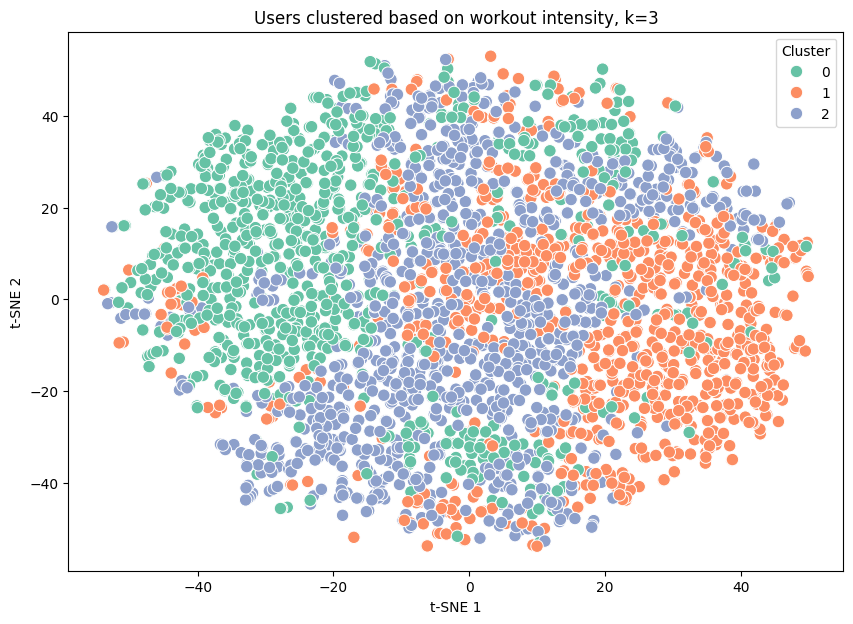

In [4]:
data = pd.read_csv('health_fitness_dataset.csv')

intensity_map = {'Low': 0, 'Medium': 1, 'High': 2}
data['intensity_numeric'] = data['intensity'].map(intensity_map)

activity_dummies = pd.get_dummies(data['activity_type'], prefix='activity')

consistency = data.groupby('participant_id').size().rename('consistency')

combined = pd.concat([
    data[['participant_id', 'intensity_numeric']],
    activity_dummies
], axis=1)

grouped = combined.groupby('participant_id').mean().reset_index()
grouped = grouped.merge(consistency, on='participant_id')

features = grouped[[
    'intensity_numeric',
    'consistency',
    *[col for col in grouped.columns if col.startswith('activity_')]
]]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

best_k = 3
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
final_labels = kmeans.fit_predict(scaled_features)

grouped['cluster'] = final_labels
grouped['silhouette_score'] = silhouette_samples(scaled_features, final_labels)

cluster_order = grouped.groupby('cluster')['intensity_numeric'].mean().sort_values()
intensity_cluster_map = {
    cluster_order.index[0]: 'Low',
    cluster_order.index[1]: 'Medium',
    cluster_order.index[2]: 'High'
} if best_k == 3 else None

if intensity_cluster_map:
    grouped['intensity_cluster'] = grouped['cluster'].map(intensity_cluster_map)

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(scaled_features)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1],
                hue=grouped['cluster'], palette='Set2', s=80)
plt.title(f'Users clustered based on workout intensity, k={best_k}')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(title='Cluster')
plt.show()



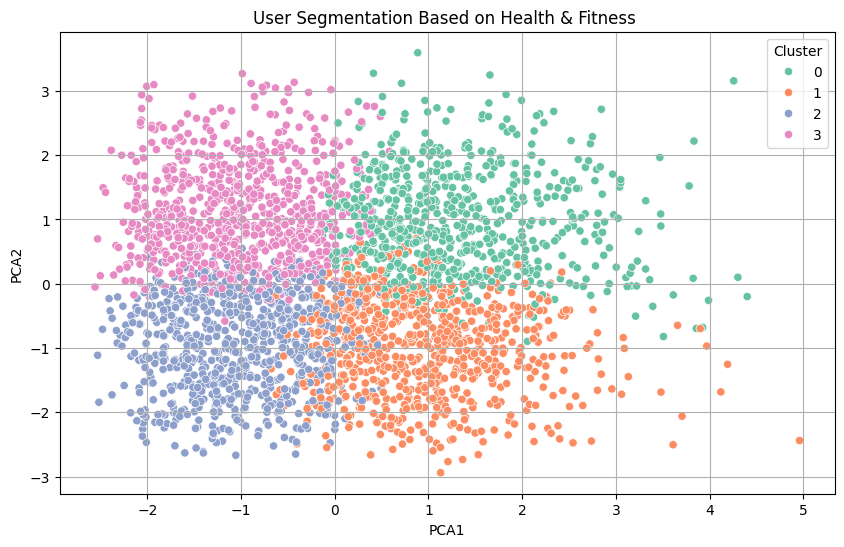

Cluster Summary:
           age    bmi  duration_minutes  calories_burned  avg_heart_rate  \
cluster                                                                    
0        31.96  23.08             95.38            32.19          144.26   
1        52.15  23.39             94.06            27.72          119.89   
2        51.57  22.88             45.92            11.94          119.81   
3        30.20  21.65             49.42            12.66          144.63   

         hours_sleep  stress_level  daily_steps  hydration_level  \
cluster                                                            
0               6.86          5.44      7569.62             2.44   
1               7.15          5.11      8065.73             2.62   
2               6.92          5.24      7726.20             2.46   
3               7.24          5.20      8234.90             2.49   

         fitness_level  
cluster                 
0                19.14  
1                18.88  
2                

In [5]:
data['date'] = pd.to_datetime(data['date'])

latest_entries = data.sort_values('date').groupby('participant_id').tail(1)

features = [
    'age', 'bmi', 'duration_minutes', 'calories_burned',
    'avg_heart_rate', 'hours_sleep', 'stress_level',
    'daily_steps', 'hydration_level', 'fitness_level'
]
X = latest_entries[features].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

k_optimal = 4
kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
latest_entries['cluster'] = kmeans.fit_predict(X_scaled)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
latest_entries['PCA1'] = X_pca[:, 0]
latest_entries['PCA2'] = X_pca[:, 1]

# Scatter plot of clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=latest_entries, x='PCA1', y='PCA2', hue='cluster', palette='Set2')
plt.title('User Segmentation Based on Health & Fitness ')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

cluster_summary = latest_entries.groupby('cluster')[features].mean().round(2)
print("Cluster Summary:")
print(cluster_summary)
